# Install pytorch
- https://pytorch.org/

1. Go to anaconda terminal as admin and enter
```bash
conda create --name pytorch_cpu python=3.12
```

2. activate environment

```bash
conda activate pytorch_cpu
```

3. install pytorch
```bash 

# CPU Only Windows and Linux
conda install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 cpuonly -c pytorch

# MAC OSX
conda install pytorch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 -c pytorch

```

4. install additional packages from dslabs and data functions
```bash
conda install pandas scikit-learn matplotlib statsmodels
```

5. if jupyter has errors run

```bash
conda install -n pytorch_cpu ipykernel --update-deps --force-reinstall
```



# DSLabs functions

In [36]:
%run "scripts/dslabs_functions.py"


# Data functions

In [37]:
%run "scripts/data_functions.py"


data_functions loaded


# Load

In [38]:
import pandas as pd
import numpy as np


file_tag = "Google Merch Store 2024-2025"


# smoothed time series with split. uncomment to use
# train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)
# test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)


# unsmoothed time series with split to test the model. uncomment to use
test_split_threshold = 0.7
data_no_smoothing=pd.read_csv('data/df_merch_0_2024_agg_time_diff_input.csv', decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)     
train, test = series_train_test_split(data_no_smoothing, trn_pct=test_split_threshold)





target='Sessions'


test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 2024-10-29 to 2025-03-05
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sessions                         128 non-null    float64
 1   Seven-day active users           128 non-null    float64
 2   28-day active users              128 non-null    float64
 3   Events per session               128 non-null    float64
 4   Add to baskets                   128 non-null    float64
 5   Checkouts                        128 non-null    float64
 6   E-commerce purchases             128 non-null    float64
 7   Average purchase revenue         128 non-null    float64
 8   Purchase revenue                 128 non-null    float64
 9   Average session duration         128 non-null    float64
 10  ARPU                             128 non-null    float64
 11  ARPPU                            128 non-null    float64
 12  Vie

# LSTM Pytorch Univariate

## Univariate Pytorch Functions and data prep

In [39]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset


def prepare_dataset_for_lstm_uni(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)


class DS_LSTM_Univariate(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm_uni(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [40]:
from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy

from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart


def lstm_study_uni(train, test, nr_episodes: int = 1000, sequence_size: list =[2,4,8], nr_hidden_units: list =[25,50,100], measure: str = "R2"):
    # sequence_size = [2, 4, 8]
    # nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm_uni(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM_Univariate(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


## Univariate Pytorch Study

seq length=5 hidden_units=5 nr_episodes=0 -0.002376079559326172
seq length=5 hidden_units=5 nr_episodes=10 0.05289721488952637
seq length=5 hidden_units=5 nr_episodes=20 0.12190306186676025
seq length=5 hidden_units=5 nr_episodes=30 0.16910266876220703
seq length=5 hidden_units=5 nr_episodes=40 0.18019461631774902
seq length=5 hidden_units=5 nr_episodes=50 0.173939049243927
seq length=5 hidden_units=5 nr_episodes=60 0.18139737844467163
seq length=5 hidden_units=5 nr_episodes=70 0.18683159351348877
seq length=5 hidden_units=5 nr_episodes=80 0.193841814994812
seq length=5 hidden_units=5 nr_episodes=90 0.1934766173362732
seq length=5 hidden_units=5 nr_episodes=100 0.20031952857971191
seq length=5 hidden_units=10 nr_episodes=0 -0.03541457653045654
seq length=5 hidden_units=10 nr_episodes=10 0.04080212116241455
seq length=5 hidden_units=10 nr_episodes=20 0.16933798789978027
seq length=5 hidden_units=10 nr_episodes=30 0.19200778007507324
seq length=5 hidden_units=10 nr_episodes=40 0.20065939

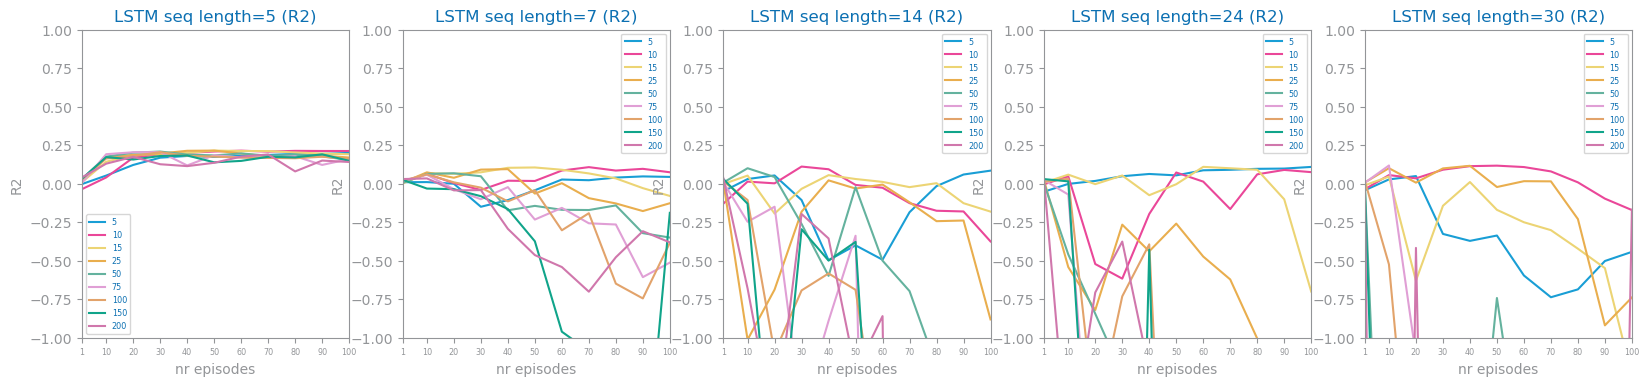

In [41]:
# # Prepare the training and testing data using the time index as the feature
from numpy import arange


train_series_float = train[[target]].values.astype("float32")
test_series_float = test[[target]].values.astype("float32")


best_model, best_params = lstm_study_uni(train_series_float,
                                         test_series_float,
                                         nr_episodes=100,
                                         sequence_size=[5,7,14,24,30],
                                         nr_hidden_units=[5,10,15,25,50,75,100,150,200],
                                         measure='R2')

## Univariate Pytorch eval

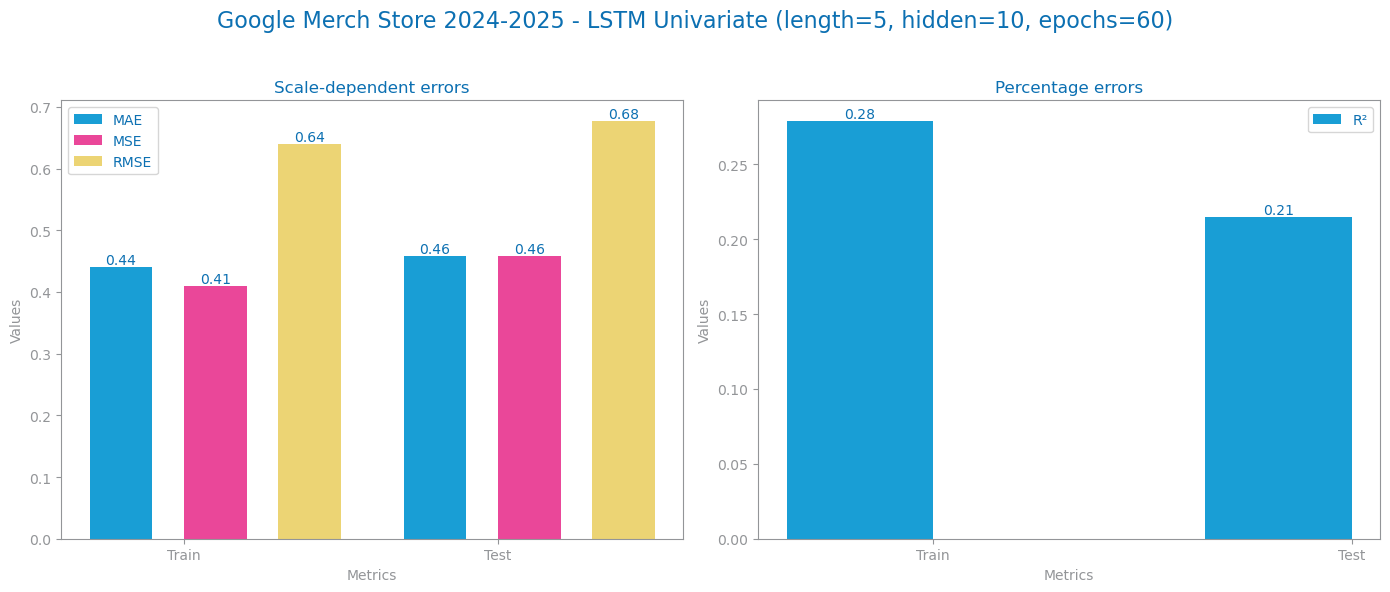

In [42]:

params = best_params["params"]
best_length = params[0]


# Assuming train and test are DataFrames with a DateTime index
trn_series = train[[target]]
tst_series = test[[target]]


trnX, trnY = prepare_dataset_for_lstm_uni(trn_series.values.astype("float32"), seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm_uni(tst_series.values.astype("float32"), seq_length=best_length)


prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

# Plot the forecasting evaluation
plot_single_model_evaluation(trn_series[best_length:], tst_series[best_length:], prd_trn, prd_tst, title=f"{file_tag} - LSTM Univariate (length={best_length}, hidden={params[1]}, epochs={params[2]})")


## Plot lstm tensorflow model univariate

<Axes: xlabel='Date', ylabel='Sessions'>

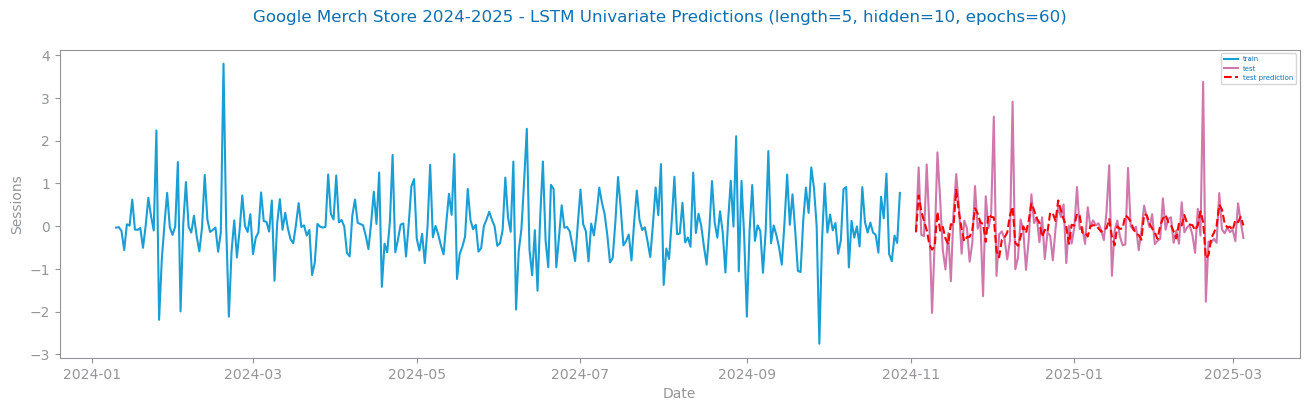

In [43]:
from pandas import Series
pred_series = Series(prd_tst.numpy().ravel(), index=tst_series.index[best_length:])


plot_forecasting_series(
    trn_series[best_length:],
    tst_series[best_length:],
    pred_series,
    title=f"{file_tag} - LSTM Univariate Predictions (length={best_length}, hidden={params[1]}, epochs={params[2]})",
    xlabel='Date',
    ylabel=target,
)

## Pytorch Univariate Model and Loss

In [44]:
model = DS_LSTM_Univariate(train_series_float, input_size=train_series_float.shape[1], hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.7976, grad_fn=<MseLossBackward0>)


# LSTM Pytorch Multivariate

## Pytorch Multivariate Functions

In [45]:
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

def prepare_dataset_for_lstm_multi(features, target, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(target) - seq_length):
        past = features[i : i + seq_length]
        future = target[i + seq_length]  # Predict the next value only
        setX.append(past)
        setY.append(future)
    setX = tensor(np.array(setX, dtype=np.float32))  # Convert to torch.float32
    setY = tensor(np.array(setY, dtype=np.float32)).view(-1, 1)  # Convert to torch.float32 and reshape
    return setX, setY


class DS_LSTM_Multivariate(Module):
    def __init__(self, trainX, trainY, input_size: int, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm_multi(trainX, trainY, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(trainX) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])  # Use the last output of the LSTM
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred

from dslabs_functions import HEIGHT, plot_multiline_chart
from copy import deepcopy
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart

def lstm_study_multi(trainX, trainY, testX, testY, nr_episodes: int = 1000,sequence_size: list =[2,4,8], nr_hidden_units: list =[25,50,100], measure: str = "R2"):
    # sequence_size = [2, 4, 8]
    # nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * HEIGHT, HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm_multi(testX, testY, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM_Multivariate(trainX, trainY, input_size=trainX.shape[1], hidden_size=hidden, length=length)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = FORECAST_MEASURES[measure](testY[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params['params'][0]} hidden_units={best_params['params'][1]} and nr_episodes={best_params['params'][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params


## Pytorch Multivariate Data Study

seq length=5 hidden_units=5 nr_episodes=0 -0.04689681529998779
seq length=5 hidden_units=5 nr_episodes=10 0.06919676065444946
seq length=5 hidden_units=5 nr_episodes=20 0.11283731460571289
seq length=5 hidden_units=5 nr_episodes=30 0.142381489276886
seq length=5 hidden_units=5 nr_episodes=40 0.17045176029205322
seq length=5 hidden_units=5 nr_episodes=50 0.18550193309783936
seq length=5 hidden_units=5 nr_episodes=60 0.19071924686431885
seq length=5 hidden_units=5 nr_episodes=70 0.1676284670829773
seq length=5 hidden_units=5 nr_episodes=80 0.15512168407440186
seq length=5 hidden_units=5 nr_episodes=90 0.13130241632461548
seq length=5 hidden_units=5 nr_episodes=100 0.12531548738479614
seq length=5 hidden_units=10 nr_episodes=0 0.0282021164894104
seq length=5 hidden_units=10 nr_episodes=10 0.1140432357788086
seq length=5 hidden_units=10 nr_episodes=20 0.13492995500564575
seq length=5 hidden_units=10 nr_episodes=30 0.10599446296691895
seq length=5 hidden_units=10 nr_episodes=40 0.0833627581

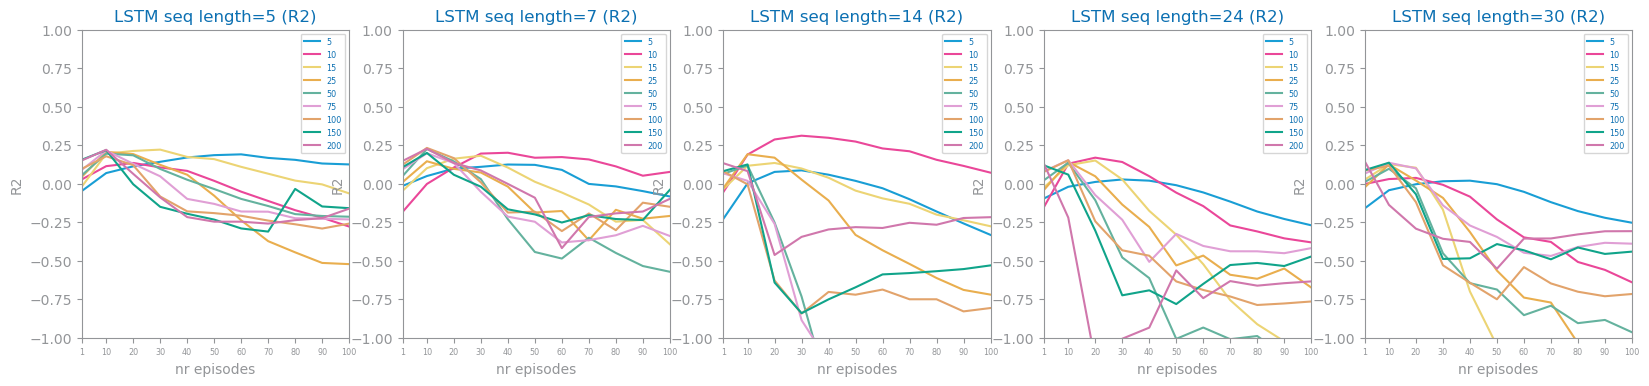

In [46]:
# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY_float = train.pop(target).values.astype(np.float32)
tstY_float = test.pop(target).values.astype(np.float32)
trnX_float = train.values.astype(np.float32)
tstX_float = test.values.astype(np.float32)

# Run the study
best_model, best_params = lstm_study_multi(trnX_float,
                                            trnY_float,
                                            tstX_float,
                                            tstY_float,
                                            nr_episodes=100,
                                            sequence_size=[5,7,14,24,30],
                                            nr_hidden_units=[5,10,15,25,50,75,100,150,200],
                                            measure='R2')



## Pytorch Multivariate Model Evaluation

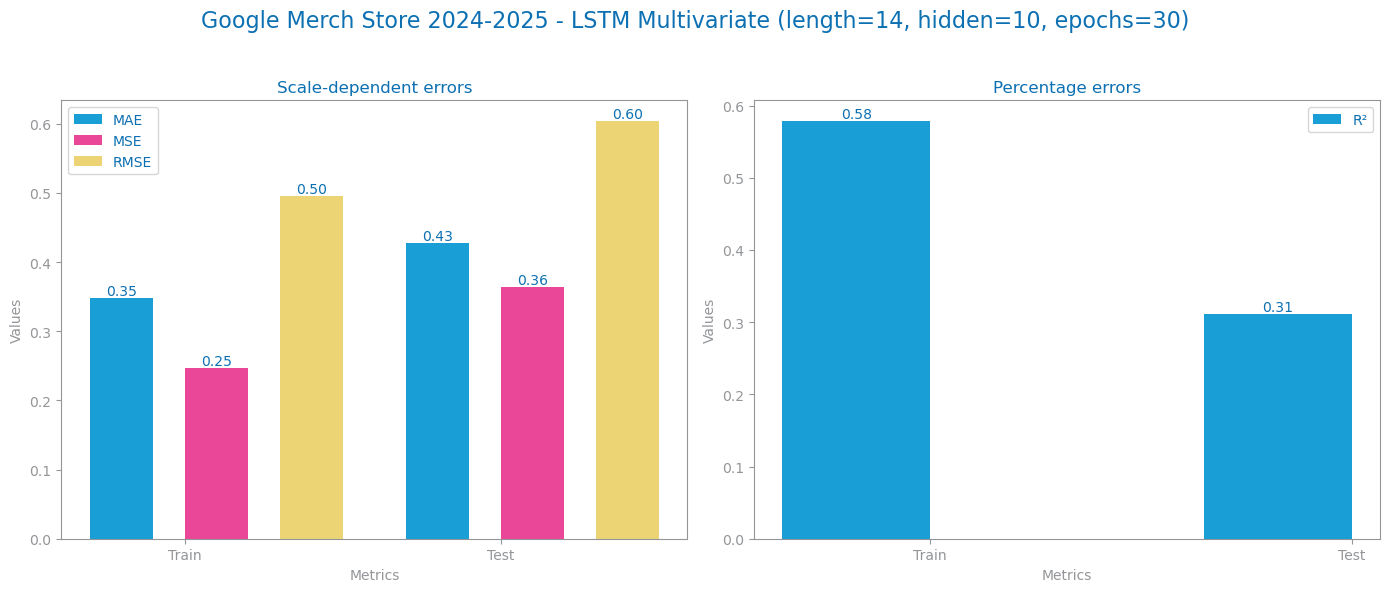

<Figure size 640x480 with 0 Axes>

In [47]:

params = best_params["params"]
best_length = params[0]


# smoothed time series with split. uncomment to use
# train=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_train.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)
# test=pd.read_csv(f"data/df_merch_0_2024_agg_time_final_test.csv", decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)


# unsmoothed time series with split to test the model. uncomment to use
test_split_threshold = 0.7
data_no_smoothing=pd.read_csv('data/df_merch_0_2024_agg_time_diff_input.csv', decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)     
train, test = series_train_test_split(data_no_smoothing, trn_pct=test_split_threshold)



# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY_float = train.pop(target).values.astype(np.float32)
tstY_float = test.pop(target).values.astype(np.float32)
trnX_float = train.values.astype(np.float32)
tstX_float = test.values.astype(np.float32)


trnX, trnY = prepare_dataset_for_lstm_multi(trnX_float, trnY_float, seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm_multi(tstX_float, tstY_float, seq_length=best_length)


prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)


# Assuming train and test are DataFrames with a DateTime index
# Reconstruct the series for plotting
train[target] = trnY_float
test[target] = tstY_float
trn_series = train[[target]]
tst_series = test[[target]]


# Plot the forecasting evaluation
plot_single_model_evaluation(trn_series[best_length:], tst_series[best_length:], prd_trn, prd_tst, title=f"{file_tag} - LSTM Multivariate (length={best_length}, hidden={params[1]}, epochs={params[2]})")
savefig(f"images/{file_tag}_LSTM_multivariate_predictions.png")

## Pytorch Multivariate Plots

<Axes: xlabel='Date', ylabel='Sessions'>

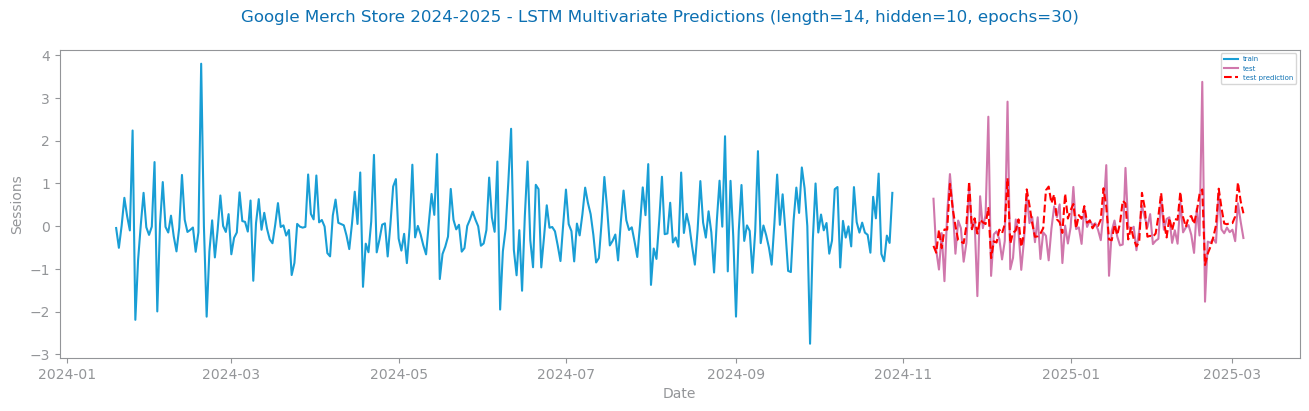

In [48]:
from pandas import Series
pred_series = Series(prd_tst.numpy().ravel(), index=tst_series.index[best_length:])


plot_forecasting_series(
    trn_series[best_length:],
    tst_series[best_length:],
    pred_series,
    title=f"{file_tag} - LSTM Multivariate Predictions (length={best_length}, hidden={params[1]}, epochs={params[2]})",
    xlabel='Date',
    ylabel=target,
)

## Pytorch Multivariate Model and Loss

In [49]:
model = DS_LSTM_Multivariate(trnX_float, trnY_float, input_size=trnX_float.shape[1], hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(3.6972, grad_fn=<MseLossBackward0>)


# Pytorch Multivariate Lagged

In [50]:


# unsmoothed time series with split to test the model. uncomment to use
test_split_threshold = 0.7
data_no_smoothing=pd.read_csv('data/df_merch_0_2024_agg_time_diff_input.csv', decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)     
train, test = series_train_test_split(data_no_smoothing, trn_pct=test_split_threshold)


def add_lagged_features(df, target, lags):
    """
    Add lagged features for the target variable based on the provided list of lags.

    Parameters:
    df (DataFrame): The input DataFrame.
    target (str): The target column name.
    lags (list): A list of integers representing the lag values.

    Returns:
    DataFrame: A new DataFrame with the target column and its lagged features.
    """
    df_lagged = df[[target]].copy()
    for lag in lags:
        df_lagged[f'{target}_lag{lag}'] = df[target].shift(lag)
    return df_lagged

# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
target = 'Sessions'
lags = [1, 7, 14]  # List of lags

# Add lagged features to the training and test sets
train_lagged = add_lagged_features(train, target, lags)
test_lagged = add_lagged_features(test, target, lags)





# Ensure all data is numeric
train_lagged = train_lagged.apply(pd.to_numeric)
test_lagged = test_lagged.apply(pd.to_numeric)

# drop any nan values
train_lagged.dropna(inplace=True)
test_lagged.dropna(inplace=True)


# Now you can use `train_lagged` and `test_lagged` in your ARIMA functions
print(train_lagged.head())

            Sessions  Sessions_lag1  Sessions_lag7  Sessions_lag14
Date                                                              
2024-01-19 -0.045206      -0.088033      -0.115394       -0.113015
2024-01-20 -0.507972      -0.045206      -0.559126       -0.548420
2024-01-21  0.007138      -0.507972       0.041637        0.023793
2024-01-22  0.661435       0.007138       0.010707        0.636452
2024-01-23  0.235547       0.661435       0.619797        0.133239


## Multi Lagged Study

seq length=5 hidden_units=5 nr_episodes=0 -0.14254486560821533
seq length=5 hidden_units=5 nr_episodes=5 -0.033756136894226074
seq length=5 hidden_units=5 nr_episodes=10 0.021072804927825928
seq length=5 hidden_units=5 nr_episodes=15 0.04494059085845947
seq length=5 hidden_units=5 nr_episodes=20 0.05537307262420654
seq length=5 hidden_units=5 nr_episodes=25 0.06666171550750732
seq length=5 hidden_units=5 nr_episodes=30 0.08000177145004272
seq length=5 hidden_units=5 nr_episodes=35 0.08961886167526245
seq length=5 hidden_units=5 nr_episodes=40 0.07974010705947876
seq length=5 hidden_units=5 nr_episodes=45 0.04966628551483154
seq length=5 hidden_units=5 nr_episodes=50 0.019822120666503906
seq length=5 hidden_units=10 nr_episodes=0 -0.08185994625091553
seq length=5 hidden_units=10 nr_episodes=5 0.010131001472473145
seq length=5 hidden_units=10 nr_episodes=10 0.044768691062927246
seq length=5 hidden_units=10 nr_episodes=15 0.08336132764816284
seq length=5 hidden_units=10 nr_episodes=20 0.1

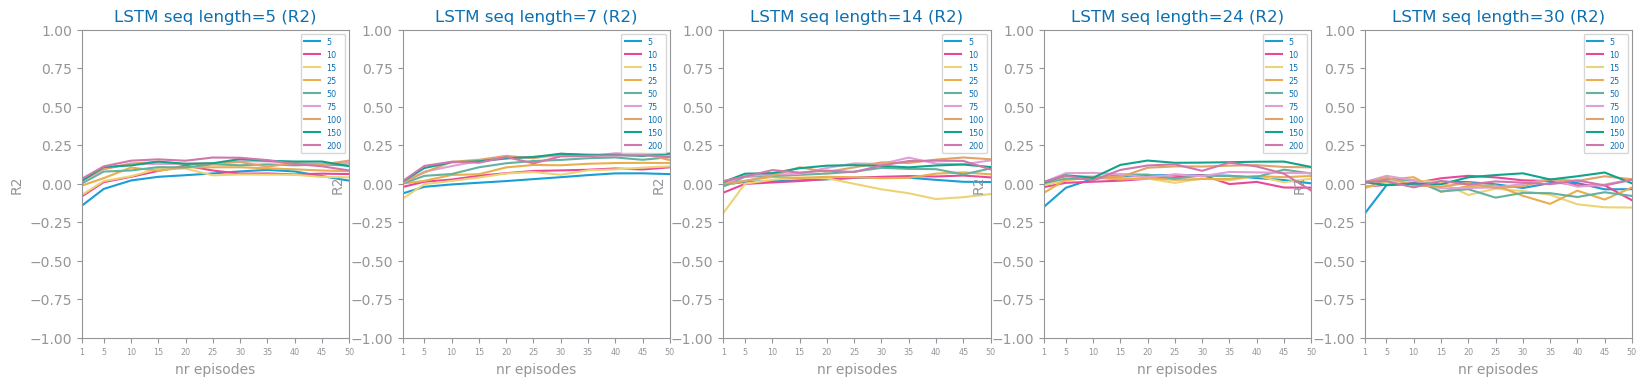

In [51]:
# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY_lagged_float = train_lagged.pop(target).values.astype(np.float32)
tstY_lagged_float = test_lagged.pop(target).values.astype(np.float32)
trnX_lagged_float = train_lagged.values.astype(np.float32)
tstX_lagged_float = test_lagged.values.astype(np.float32)

# Run the study
best_model, best_params = lstm_study_multi(trnX_lagged_float,
                                            trnY_lagged_float,
                                            tstX_lagged_float,
                                            tstY_lagged_float,
                                            nr_episodes=50,
                                            sequence_size=[5,7,14,24,30],
                                            nr_hidden_units=[5,10,15,25,50,75,100,150,200],
                                            measure='R2')

## Multivatiate Lagged Evaluate

In [52]:

params = best_params["params"]
best_length = params[0]


# unsmoothed time series with split to test the model. uncomment to use
test_split_threshold = 0.7
data_no_smoothing=pd.read_csv('data/df_merch_0_2024_agg_time_diff_input.csv', decimal=".",  index_col='Date', parse_dates=True,  infer_datetime_format=True)     
train, test = series_train_test_split(data_no_smoothing, trn_pct=test_split_threshold)


def add_lagged_features(df, target, lags):
    """
    Add lagged features for the target variable based on the provided list of lags.

    Parameters:
    df (DataFrame): The input DataFrame.
    target (str): The target column name.
    lags (list): A list of integers representing the lag values.

    Returns:
    DataFrame: A new DataFrame with the target column and its lagged features.
    """
    df_lagged = df[[target]].copy()
    for lag in lags:
        df_lagged[f'{target}_lag{lag}'] = df[target].shift(lag)
    return df_lagged

# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
target = 'Sessions'
lags = [1, 7, 14]  # List of lags

# Add lagged features to the training and test sets
train_lagged = add_lagged_features(train, target, lags)
test_lagged = add_lagged_features(test, target, lags)





# Ensure all data is numeric
train_lagged = train_lagged.apply(pd.to_numeric)
test_lagged = test_lagged.apply(pd.to_numeric)

# drop any nan values
train_lagged.dropna(inplace=True)
test_lagged.dropna(inplace=True)


# Example usage
# Assuming `train` and `test` are your DataFrames and `target` is the target column name
trnY_lagged_float = train_lagged.pop(target).values.astype(np.float32)
tstY_lagged_float = test_lagged.pop(target).values.astype(np.float32)
trnX_lagged_float = train_lagged.values.astype(np.float32)
tstX_lagged_float = test_lagged.values.astype(np.float32)



trnX, trnY = prepare_dataset_for_lstm_multi(trnX_lagged_float, trnY_lagged_float, seq_length=best_length)
tstX, tstY  = prepare_dataset_for_lstm_multi(tstX_lagged_float, tstY_lagged_float, seq_length=best_length)


prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)


# Assuming train and test are DataFrames with a DateTime index
# Reconstruct the series for plotting
train[target] = trnY_lagged_float
test[target] = tstY_lagged_float
trn_series = train[[target]]
tst_series = test[[target]]


# Plot the forecasting evaluation
# plot_single_model_evaluation(trn_series[best_length:], tst_series[best_length:], prd_trn, prd_tst, title=f"{file_tag} - LSTM Multivariate (length={best_length}, hidden={params[1]}, epochs={params[2]})")
# savefig(f"images/{file_tag}_LSTM_multivariate_predictions.png")

ValueError: Length of values (284) does not match length of index (298)